In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from random import randint
import scipy.stats as st
from scipy.signal import correlate2d, convolve2d
from scipy.ndimage.filters import laplace 
import collections
%matplotlib inline

In [2]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def P2R(radii, angles):
    return radii * np.exp(1j*angles)

def R2P(x):
    return np.abs(x), np.angle(x)

def LaplacianInterriorDomain(Image):
    M=len(Image)
    N=len(Image[0])
    u=np.copy(Image)
    DeltaU=laplace(u)
    v1=np.zeros([M,N])
    v2=np.zeros([M,N])
    for y in range(N):
        v1[0,y]=u[M-1,y]-u[0,y]
        v1[M-1,y]=u[0,y]-u[M-1,y]
    for x in range(M):
        v2[x,0]=u[x,N-1]-u[x,0]
        v2[x,N-1]=u[x,0]-u[x,N-1]
    v=v1+v2
    return(DeltaU-v)

In [3]:
def PeriodicComponent(Image):
    M=len(Image)
    N=len(Image[0])
    LapFFT=np.fft.fft2(LaplacianInterriorDomain(Image))
    PFFT=np.zeros([M,N],dtype=np.complex)
    for i in range(M):
        for j in range(N):
            if (i==0 and j==0):
                PFFT[i,j]=np.sum(np.ravel(Image))
            else:
                PFFT[i,j]=LapFFT[i,j]/(2*np.cos(2*i*math.pi/M)+2*np.cos(2*j*math.pi/N)-4)
    P=np.fft.ifft2(PFFT)
    return(P)

def ExpandTexture(Image,S0,S1):
    M=len(Image)
    N=len(Image[0])
    m=np.mean(Image.ravel())
    P=np.abs(PeriodicComponent(Image))
    Texture=np.ones([S0,S1])*m
    Texture[(S0/2-M/2):(S0/2-M/2+M),(S1/2-N/2):(S1/2-N/2+N)]=m*np.ones_like(P)+(P-m*np.ones_like(P))*np.sqrt(S0*S1/(M*N))
    TextureFFT=np.fft.fft2(Texture)
    norm, phase = R2P(TextureFFT)
    RandomPhase=np.random.rand(S0,S1)*2*math.pi-np.ones([S0,S1])*math.pi
    NTextureFFT=P2R(norm,phase+RandomPhase)
    return(np.abs(np.fft.ifft2(NTextureFFT)))

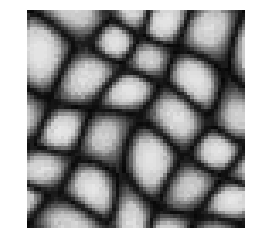

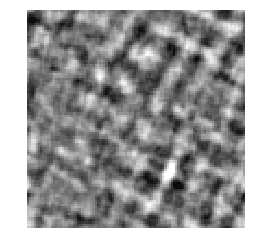

In [14]:
img=rgb2gray(np.array(mpimg.imread('../../161.gif'))[:,:,:3])
plt.imshow(img,cmap='gray',vmax=255,vmin=0)
plt.axis('off')
plt.show()
a=ExpandTexture(np.array(img,dtype=np.float),100,100)
plt.imshow(a,cmap='gray',vmax=255,vmin=0)
plt.axis('off')
plt.show()